**Stat 451 Final Project- Models**

*Dylan Asoh, Logan O'Brien, Samuel Peterson*

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import rfpimp
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_csv('ohe.csv')

In [3]:
data = data.drop('Unnamed: 0', axis=1)
y = data["log_price"]
x = data.drop('log_price', axis=1)
x.head()

#x2 used to test partitions of data in models, tried several versions but none were more effective than entire dataset
x2 = x[['Entire home/apt', 'accommodates', 'Private room', 'bathrooms', 'number_of_reviews', 'amenities', 'SF', 'LA', 'bedrooms', 'House', 'Chicago', 'DC', 'beds', 'instant_bookable', 'Condominium']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

**Linear Regression**

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Training accuracy: " + str(lr.score(X_train, y_train)))
print("Testing accuracy: " + str(lr.score(X_test, y_test)))

Training accuracy: 0.5603118701058252
Testing accuracy: 0.5506178294825163


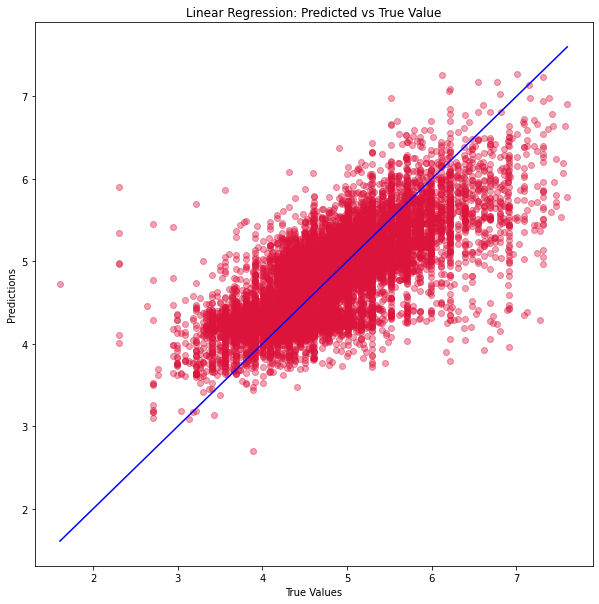

In [8]:
#Creating plot to examine true value vs predicted of base linear regression model
predictions = lr.predict(X_test)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, predictions, c='crimson', alpha=0.4)

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
ax.plot([p1, p2], [p1, p2], 'b-')

ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')
ax.set_title('Linear Regression: Predicted vs True Value')
fig.savefig('LR_Pred_vs_True.png')

**LinearSVR**

In [6]:
pipeline = Pipeline(steps=[('std', StandardScaler()), ('lsvr', LinearSVR())])
pipeline.fit(X_train, y_train)
print("Training accuracy: " + str(pipeline.score(X_train, y_train)))
print("Testing accuracy: " + str(pipeline.score(X_test, y_test)))

Training accuracy: 0.5491901627122507
Testing accuracy: 0.5422208914737214


**XGBoost**

In [7]:
#Much better than linear regression, even as a base model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
print("Training accuracy: " + str(xgb.score(X_train, y_train)))
print("Testing accuracy: " + str(xgb.score(X_test, y_test)))

Training accuracy: 0.6634540240420079
Testing accuracy: 0.614155288847007


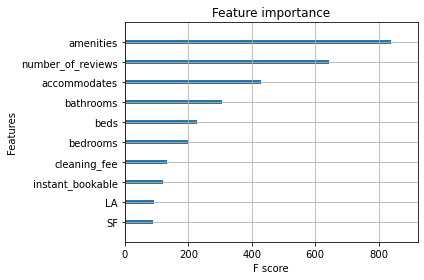

In [8]:
#Examining feature importance of base XGBRegressor model
ax = plot_importance(xgb, max_num_features=10, show_values=False)
ax.figure.tight_layout()
ax.figure.savefig('XGB_Importance.png')

In [9]:
xgb = XGBRegressor()
params = {'max_depth': [3,6,12,15]}
cv = GridSearchCV(xgb,param_grid=params, cv=2)
cv.fit(X_train, y_train)
print("Training accuracy: " + str(cv.score(X_train, y_train)))
print("Testing accuracy: " + str(cv.score(X_test, y_test)))

Training accuracy: 0.6208490664613329
Testing accuracy: 0.6050110944459604


In [ ]:
cv.best_params_

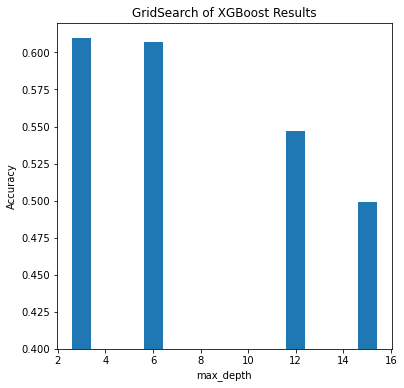

In [10]:
cv.cv_results_['mean_test_score']
fig, ax = plt.subplots(figsize=(6, 6))
ax.bar([3,6,12,15],cv.cv_results_['mean_test_score'],align='center')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.set_title('GridSearch of XGBoost Results')
ax.set_ylim([0.4, 0.62])
fig.savefig('GS_XGB_Results.png')

**Adaboost**

In [12]:
#Low performing model, little evidence of overfitting or underfitting though
params = {'n_estimators': [2, 5, 10, 15]}
regr = AdaBoostRegressor(random_state=0)
cv = GridSearchCV(regr, param_grid=params, scoring='accuracy', refit=True, n_jobs = -1)
cv.fit(X_train, y_train)
print(cv.best_estimator_)
print(f"Training accuracy: {cv.best_estimator_.score(X_train, y_train)*100:0.3f}%")
print(f"Testing accuracy: {cv.best_estimator_.score(X_test, y_test)*100:0.3f}%")

AdaBoostRegressor(n_estimators=2, random_state=0)
Training accuracy: 50.939%
Testing accuracy: 50.198%


In [13]:
cv.best_params_

{'n_estimators': 2}

**KNN**

In [14]:
#Overfit the data
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
print("Training accuracy: " + str(knn.score(X_train, y_train)))
print("Testing accuracy: " + str(knn.score(X_test, y_test)))

Training accuracy: 0.6521871417294212
Testing accuracy: 0.4836008291311946


In [15]:
#A little less overfit, but not a great model of our data
knn = KNeighborsRegressor()
params = {'knn__n_neighbors':[3, 5, 7, 9]}
std = StandardScaler()
pipeline = Pipeline(steps=[('std', std), ('knn', knn)])
cv = GridSearchCV(pipeline, param_grid=params, cv=3)

cv.fit(X_train, y_train)
print("Training accuracy: " + str(cv.score(X_train, y_train)))
print("Testing accuracy: " + str(cv.score(X_test, y_test)))

Training accuracy: 0.6468780435008625
Testing accuracy: 0.5525257984753571


In [16]:
cv.best_params_

{'knn__n_neighbors': 9}

**LightGBM**

In [17]:
#This base LightBGM was promising, with a higher test accuracy than most models so far
gbm = lgb.LGBMRegressor()
gbm.fit(X_train, y_train)
print("Training accuracy: " + str(gbm.score(X_train, y_train)))
print("Testing accuracy: " + str(gbm.score(X_test, y_test)))

Training accuracy: 0.6359502957365819
Testing accuracy: 0.6132139199627463


In [11]:
#Ended as our highest performing model
gbm_best = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=1000)
params = {'num_leaves':[75, 100, 125],
         'max_depth': [23, 24, 25]}
gbm = lgb.LGBMRegressor()
gbm_best = GridSearchCV(gbm, param_grid=params, cv=3)
gbm_best.fit(X_train, y_train)
predict_best = gbm_best.predict(X_test)
print("Training accuracy: " + str(gbm_best.score(X_train, y_train)))
print("Testing accuracy: " + str(gbm_best.score(X_test, y_test)))

Training accuracy: 0.6588967318972783
Testing accuracy: 0.6163557934810971


In [13]:
gbm_best.best_params_

{'max_depth': 25, 'num_leaves': 75}

In [20]:
#Used in Final Report in Table 2
results_grid = pd.concat([pd.DataFrame(gbm_best.cv_results_["params"]),pd.DataFrame(gbm_best.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
results_grid

,max_depth,num_leaves,Accuracy
0,23,75,0.614856
1,23,100,0.613824
2,23,125,0.611881
3,24,75,0.614853
4,24,100,0.613934
5,24,125,0.612074
6,25,75,0.614922
7,25,100,0.613695
8,25,125,0.612368


**L1 and L2 Regularization**

*Ridge, Lasso, ElasticNet*

In [33]:
#Attempting L2 regularization, fairly decent model
ridge = Ridge()
params = {"alpha":[0, 0.25, 0.5, 0.75, 1.0, 2.0 , 3.0, 4.0 ,5.0]}
cv = GridSearchCV(ridge, param_grid=params)
cv.fit(X_train, y_train)
print("Training accuracy: " + str(cv.score(X_train, y_train)))
print("Testing accuracy: " + str(cv.score(X_test, y_test)))

Training accuracy: 0.560224642035525
Testing accuracy: 0.5506100827023865


In [34]:
cv.best_params_

{'alpha': 4.0}

In [35]:
#L1 regularization, also not a bad fit
lasso = Lasso(max_iter=10000) 
params = {"alpha":[0, 0.25, 0.5, 0.75, 1.0, 2.0 , 3.0, 4.0 ,5.0]}
cv = GridSearchCV(lasso, param_grid=params)
cv.fit(X_train, y_train)
print("Training accuracy: " + str(cv.score(X_train, y_train)))
print("Testing accuracy: " + str(cv.score(X_test, y_test)))

Training accuracy: 0.5603118701058252
Testing accuracy: 0.5506117956093786


In [36]:
cv.best_params_

{'alpha': 0}

In [25]:
#Combining L1 and L2 regularization, poor model performance on both train and test
el = ElasticNet(random_state=0)
params={'alpha':[0.5, 1.0, 2.0, 3.0, 4.0, 5.0], 'l1_ratio':[0.1,0.3,0.5]}
cv = GridSearchCV(el, param_grid=params)
cv.fit(X_train, y_train)
print("Training accuracy: " + str(cv.score(X_train, y_train)))
print("Testing accuracy: " + str(cv.score(X_test, y_test)))

Training accuracy: 0.39162455037784005
Testing accuracy: 0.3853633309738089


In [26]:
cv.best_params_

{'alpha': 0.5, 'l1_ratio': 0.1}

**Bagging**

In [27]:
#Very overfitted model
bag = BaggingRegressor(n_estimators=25)
bag.fit(X_train, y_train)
print("Training accuracy: " + str(bag.score(X_train, y_train)))
print("Testing accuracy: " + str(bag.score(X_test, y_test)))

Training accuracy: 0.896082354962502
Testing accuracy: 0.5586603247575472


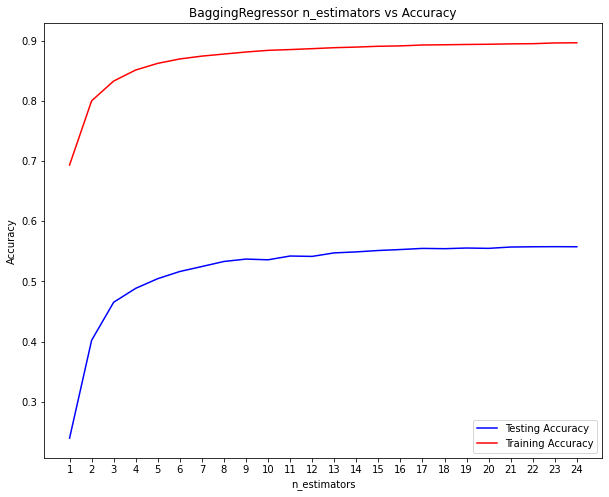

In [28]:
#Changing n_estimators did nothing for model overfitting 
#however it was interesting to see the BaggingRegressor learn with more n_estimators
n_estimators = np.arange(1, 25)
train_acc = []
test_acc = []

for i,num in enumerate(n_estimators):
    bag = BaggingRegressor(n_estimators=num)
    bag.fit(X_train, y_train)
    train_acc.append(bag.score(X_train, y_train))
    test_acc.append(bag.score(X_test, y_test))

plt.figure(figsize=[10,8])
plt.plot(n_estimators, test_acc, label = 'Testing Accuracy', color='Blue')
plt.plot(n_estimators, train_acc, label = 'Training Accuracy', color='Red')
plt.legend()
plt.title('BaggingRegressor n_estimators vs Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.xticks(n_estimators)
plt.savefig('BaggingEstimatorsVsAccuracy.png')
plt.show()

**Random Forest**

In [41]:
#Fairly well performing model, which is expected
rf = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [5,10,25,50,100],
         'max_depth': [2,5,10,15]}
cv = GridSearchCV(rf,param_grid=params, cv=3)
cv.fit(X_train, y_train)
print("Training accuracy: " + str(cv.score(X_train, y_train)))
print("Testing accuracy: " + str(cv.score(X_test, y_test)))

Training accuracy: 0.6461943900954301
Testing accuracy: 0.60303653628374


In [42]:
cv.best_params_

{'max_depth': 10, 'n_estimators': 100}

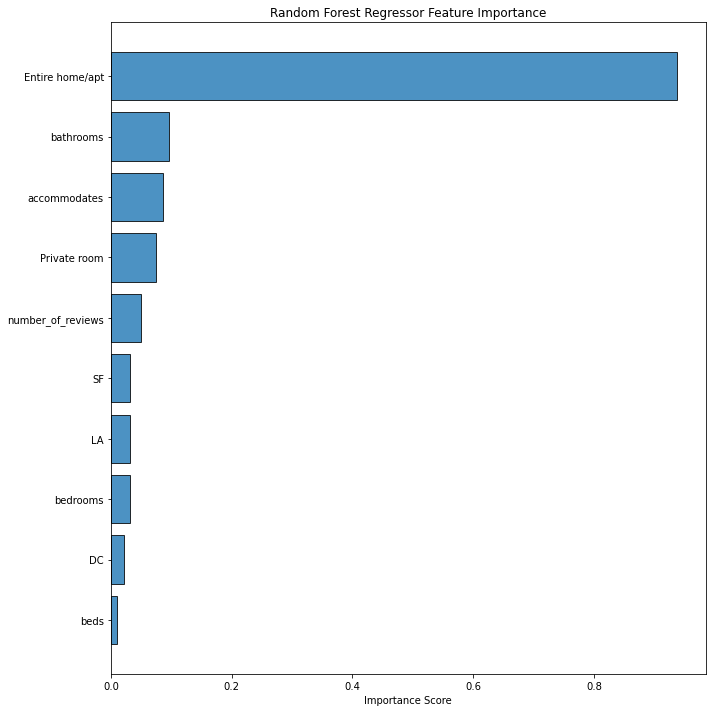

In [47]:
imp = rfpimp.importances(rf, X_test, y_test)
fig, ax = plt.subplots(figsize=(10, 10))
x = imp.index[:10]
y = imp['Importance'][:10]
ax.barh(x, y, height=0.8, alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance Score')
ax.set_title('Random Forest Regressor Feature Importance')
plt.gca().invert_yaxis()
fig.tight_layout()
fig.savefig('RF_Importance.png')

**Stacking**

In [43]:
#Tried the following estimators, no real success but worth noting

# estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=1))]
# estimators = [('xgb', XGBRegressor()),('lr', LinearRegression())]

#Acheived a solid model with the following pipelines and estimators
svr_pipeline = Pipeline(steps=[('std', StandardScaler()), ('svr', LinearSVR(random_state=0))])
knn_pipeline = Pipeline(steps=[('std', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=9))])
estimators = [('xgb', XGBRegressor()),('svr_pipe', svr_pipeline), ('knn_pipeline', knn_pipeline)]
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)
)
reg.fit(X_train, y_train)
print("Training accuracy: " + str(reg.score(X_train, y_train)))
print("Testing accuracy: " + str(reg.score(X_test, y_test)))

Training accuracy: 0.6620544876904514
Testing accuracy: 0.6104084525493245
